In [42]:
#importamos los paquetes necesarios para la ejecución del código
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import accuracy_score,confusion_matrix,balanced_accuracy_score,f1_score,roc_auc_score,cohen_kappa_score

----------------------------------
DEPURACIÓN DE LOS DATOS
------------------------------------

In [43]:
#cargamos el excel al completo en la variable df
df = pd.read_excel('Datos/Calidad_Diagnóstico_Fotos.xlsx', sheet_name = 'Resultados', skiprows = 1)

In [44]:
#eliminamos las columnas de la 5 a la 8 y de la 10 a la 23 porque no aportan información relevante
df.drop(df.columns[10:24], axis = 1, inplace = True)
df.drop(df.columns[5:9], axis = 1, inplace = True)
NHC_validos = set(df['NHC'])

In [45]:
#obtenemos los NHC de todos los pacientes con algún valor missing en alguna columna
NA_values = set(df[df.isna().any(axis = 1)]['NHC'])
NHC_validos = NHC_validos - NA_values

In [46]:
#eliminamos todos los pacientes cuyo NHC esté en la lista NA_values
df.drop(df[df['NHC'].isin(NA_values) == True].index, inplace = True)

In [47]:
#a continuación obtenemos los NHC de todos aquellos pacientes que no posean las 12 filas necesarias
no_12filas = set(filter(lambda x: list(df['NHC']).count(x) != 12, NHC_validos))
NHC_validos = NHC_validos - no_12filas

In [48]:
#y los eliminamos del dataframe 
df.drop(df[df['NHC'].isin(no_12filas) == True].index, inplace = True)

In [49]:
#por último vamos a comprobar si esas 12 filas están bien distribuidas (4 filas por aparato, 6 para cada ojo, y 6 para cada retinólogo)
no_distribuidos = set()
for i in NHC_validos:
    if list(df[df['NHC'] == i]['1 OCT 2 IPHONE 3 SAMSUNG']).count(1) != 4 or list(df[df['NHC'] == i]['1 OCT 2 IPHONE 3 SAMSUNG']).count(2) != 4 or list(df[df['NHC'] == i]['1 OCT 2 IPHONE 3 SAMSUNG']).count(3) != 4:
        no_distribuidos.add(i)
    if list(df[df['NHC'] == i]['lateralidad 1 Dch 2 izq']).count(1) != 6 or list(df[df['NHC'] == i]['lateralidad 1 Dch 2 izq']).count(2) != 6:
        no_distribuidos.add(i)
    if list(df[df['NHC'] == i]['Retinlogo 1 y 2']).count(1) != 6 or list(df[df['NHC'] == i]['Retinlogo 1 y 2']).count(2) != 6:
        no_distribuidos.add(i)

NHC_validos = NHC_validos - no_distribuidos

In [50]:
#y eliminamos del dataframe los pacientes con filas mal distribuidas
df.drop(df[df['NHC'].isin(no_distribuidos) == True].index, inplace = True)

In [51]:
#vamos a comprobar qué filas de cada dataset tienen sus 6 imágenes correspondientes
fotos_OCT = [i.upper() for i in os.listdir('Datos/Raw Data/FOTOS OCT')]
fotos_iphone = [i.upper() for i in os.listdir('Datos/Raw Data/FOTOS iPhone')]
fotos_samsung = [i.upper() for i in os.listdir('Datos/Raw Data/FOTOS Samsung')]

no_foto = set()

for i in NHC_validos:
    oct_der = str(int(i)).upper() + "TD.JPG"
    oct_izq = str(int(i)).upper() + "TI.JPG"
    iphone_der = str(int(i)).upper() + "ED.PNG"
    iphone_izq = str(int(i)).upper() + "EI.PNG"
    samsung_der = str(int(i)).upper() + "GD.PNG"
    samsung_izq = str(int(i)).upper() + "GI.PNG"
    
    if oct_der not in fotos_OCT or oct_izq not in fotos_OCT or iphone_der not in fotos_iphone or iphone_izq not in fotos_iphone or samsung_der not in fotos_samsung or samsung_izq not in fotos_samsung:
        no_foto.add(i)

#eliminamos los pacientes que no tienen las 6 imágenes
NHC_validos = NHC_validos - no_foto

In [52]:
#por último eliminamos aquellos pacientes que no poseen las 6 fotos
df.drop(df[df['NHC'].isin(no_foto) == True].index, inplace = True)

In [53]:
#creamos 3 sub-dataframe,dependiendo del tipo de instrumento empleado para tomar las imágenes 
retin = df[df['1 OCT 2 IPHONE 3 SAMSUNG'] == 1]
iphone = df[df['1 OCT 2 IPHONE 3 SAMSUNG'] == 2]
samsung = df[df['1 OCT 2 IPHONE 3 SAMSUNG'] == 3]

In [54]:
#para finalizar esta primera parte vamos a definir la función factorizar que convierte los campos de Grado y Clasificación de numérico a tipo String
def factorizar(df, columnas = ["GRADO RETINOPATÍA DIABÉTICA", "Clasificación EMD. 1 NO . 2 NO CENTRAL, 3 CENTRAL"]):
    '''
    Transforma las columnas del Grado y Clasificación EMD de tipo numérico a tipo String, ya que nuestro problema ha de ser un problema de etiquetado multiclases, no un problema numérico.
    
    Parámetros
    ----------------------------------------------------------------------
    df: pandas.DataFrame sobre el cual se van a efectuar las modificaciones de las columnas.
    columnas: una lista que contiene los nombres de las columnas que se desean modificar. Por defecto es una lista que contiene el nombre de las columnas correspondientes al Grado y la Clasificación EMD.
    
    Return
    ----------------------------------------------------------------------
    df: pandas.DataFrame idéntico al introducido como parámetro pero con las columnas ya modificadas.
    '''
    i = 0
    while i<len(columnas):
        df[columnas[i]] = df[columnas[i]].map({1.0:'uno',
                                               2.0:'dos',
                                               3.0:'tres',
                                               4.0:'cuatro',
                                               5.0:'cinco',
                                               'uno':'uno',
                                               'dos':'dos',
                                               'tres':'tres',
                                               'cuatro':'cuatro',
                                               'cinco':'cinco'})
        i += 1
    
    return df

Como los valores de grado de retinopatía del OCT son los que vamos a emplear como salidas en el proceso de entrenamiento, necesitamos unificar sus valores. Por ello en los casos en que encontramos discrepancias vamos a sustituir el diagnóstico más favorable por el menos favorable (siempre es preferente sobrediagnosticar un caso negativo que no detectar uno positivo).

In [55]:
#declaro una función que sustituye el mejor por el peor diagnóstico en aquellos discrepantes
def reemplaza_diagnostico(df):
    '''
    Comprueba qué imágenes poseen un diagnóstico discrepante, y en aquellas donde se cumpla esta condición reemplaza el diagnóstico más leve (más bajo numéricamente) por aquel de mayor gravedad (más alto numéricamente).
    
    Parámetros
    ----------------------------------------------------------------------
    df: pandas.DataFrame correspondiente a la tabla en la que se encuentra la información a cotejar.
    
    Return
    ----------------------------------------------------------------------
    df: pandas.DataFrame con los valores de los diagnósticos ya actualizados (se devuelve el DataFrame factorizado, convirtiendo el Grado y Clasificación nuevamente a tipo String)
    '''
    df.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
    k = 0
    while k<(len(df)-1):
        if df.iloc[k,5] != df.iloc[k+1,5]:
            if df.iloc[k,5] > df.iloc[k+1,5]:
                df.iloc[k+1,5] = df.iloc[k,5]
            else:
                df.iloc[k,5] = df.iloc[k+1,5]
        if df.iloc[k,6] != df.iloc[k+1][6]:
            if df.iloc[k,6] > df.iloc[k+1,6]:
                df.iloc[k+1,6] = df.iloc[k,6]
            else:
                df.iloc[k,6] = df.iloc[k+1,6]
        k+=2
    return factorizar(df)

In [56]:
#homogeneizamos los diagnósticos de los 3 sub-dataframes creados anteriormente
retin = reemplaza_diagnostico(retin)
samsung = reemplaza_diagnostico(samsung)
iphone = reemplaza_diagnostico(iphone)

C:\Users\samue\AppData\Local\Temp\ipykernel_7536\2019173532.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
C:\Users\samue\AppData\Local\Temp\ipykernel_7536\3291959763.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas[i]] = df[columnas[i]].map({1.0:'uno',
C:\Users\samue\AppData\Local\Temp\ipykernel_7536\3291959763.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

----------------------------
OBTENCIÓN DE MÉTRICAS
-----------------------------

Una vez depurados los datos y homogeneizados los diagnósticos de los clínicos, vamos a obtener distintas métricas que nos permitirán evaluar el grado de acierto de los retinólogos sobre el conjunto de imágenes de iPhone y Samsung. Para ello se considerará como 'gold standard' el diagnóstico realizado por los retinólogos sobre las imágenes de OCT.

Para poder comparar los diagnósticos sobre las imágenes de OCT con los diagnósticos con imágenes de iPhone y Samsung lo primero que debemos hacer es ordenar de manera idéntica los 3 sub-datasets. De esta forma la correspondencia entre filas de los sub-datasets será la que nos permita hacer la comparación.

In [57]:
#ordenamos los datasets en función del número de historia clínica y la lateralidad del ojo (derecho o izquierdo)
retin.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
samsung.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
iphone.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)

C:\Users\samue\AppData\Local\Temp\ipykernel_7536\1903901588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retin.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
C:\Users\samue\AppData\Local\Temp\ipykernel_7536\1903901588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samsung.sort_values(['NHC','lateralidad 1 Dch 2 izq'], inplace = True)
C:\Users\samue\AppData\Local\Temp\ipykernel_7536\1903901588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Ahora sabemos que los dataframes _retin, iphone_ y _samsung_ poseen los mismos números de historia clínica y en el mismo orden, que la lateralidad de los ojos sigue el siguiente patrón: 1,1,2,2,1,1,2,2,1,1,2,2... y que el retinólogo va alternando entre filas de la siguiente manera: 2,1,2,1,2,1,2,1,... Todas estas conclusiones las sabemos porque hemos ordenado anteriormente los 3 datasets según la columna de NHC y de lateralidad, y hemos cribado todas las filas hasta quedarnos exclusivamente con aquellas comunes a los 3 dataframes.

Es por ello que sabemos que la fila X de la columna _GRADO RETINOPATÍA DIABÉTICA_ se corresponde con el mismo número de historia clínica en las 3 tablas.

In [58]:
#vamos a igualar los índices de todas las tablas, para poder facilitar la comparación entre ellas más adelante
retin.reset_index(drop = True, inplace = True)
samsung.reset_index(drop = True, inplace = True)
iphone.reset_index(drop = True, inplace = True)

In [59]:
#almacenamos en la variable grado_golds_1 los resultados del diagnóstico del grado usando el gold standard (OCT)
grado_golds = retin.iloc[:,5:6]

In [60]:
#por último cargamos los diagnósticos del grado de retinopatía para fotos con iPhone y con Samsung
grado_iphone = iphone.iloc[:, 5:6]
grado_samsung = samsung.iloc[:,5:6]

En el proceso de evaluación se van a obtener las siguientes métricas:
 - accuracy
 - balanced accuracy
 - f-score
 - AUC de la curva ROC
 - Quadratic Weighted Kappa

--------------------------
ACCURACY
---------------------------

Además del valor de accuracy, se va a obtener la matriz de confusión para el diagnóstico con imágenes de iPhone y con imágenes de Samsung. Se empleará el paquete seaborn para lograr una mejor representación de la matriz.

Acierto en el diagnóstico del grado con fotos de iPhone: 0.5508474576271186

AxesSubplot(0.125,0.125;0.775x0.755)


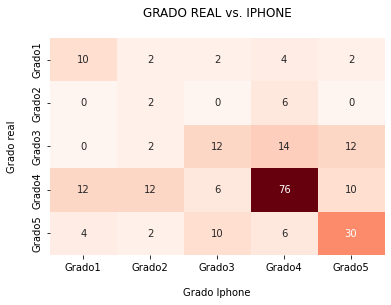

In [61]:
matriz_grado_iphone = confusion_matrix(y_true = grado_golds,y_pred = grado_iphone)

print(f"Acierto en el diagnóstico del grado con fotos de iPhone: {accuracy_score(grado_golds, grado_iphone)}\n")

plot = sns.heatmap(matriz_grado_iphone, annot = True, cmap = 'Reds', cbar = False)
plot.set_title('GRADO REAL vs. IPHONE\n')
plot.set_xlabel('\nGrado Iphone')
plot.set_ylabel('Grado real\n')
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

Acierto en el diagnóstico del grado con fotos de Samsung: 0.5508474576271186 

AxesSubplot(0.125,0.125;0.775x0.755)


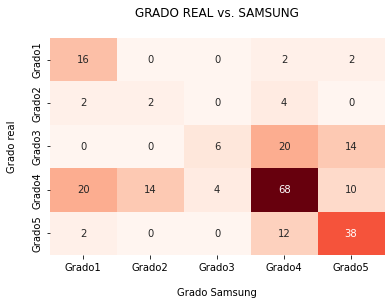

In [62]:
matriz_grado_samsung = confusion_matrix(grado_golds,grado_samsung)

print(f"Acierto en el diagnóstico del grado con fotos de Samsung: {accuracy_score(grado_golds, grado_samsung)} \n")

plot = sns.heatmap(matriz_grado_samsung, annot = True, cmap = 'Reds', cbar = False)
plot.set_title('GRADO REAL vs. SAMSUNG\n')
plot.set_xlabel('\nGrado Samsung')
plot.set_ylabel('Grado real\n')
plot.xaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
plot.yaxis.set_ticklabels(['Grado1','Grado2','Grado3','Grado4','Grado5'])
print(plot)

---------------------------------
BALANCED ACCURACY
----------------------------------

In [40]:
bal_acc_gr_iphone = balanced_accuracy_score(y_true = grado_golds, y_pred = grado_iphone)
print(f"Valor de balanced accuracy para el grado con iPhone: {bal_acc_gr_iphone}")

Valor de balanced accuracy para el grado con iPhone: 0.4564190981432361


In [41]:
bal_acc_gr_samsung = balanced_accuracy_score(y_true = grado_golds, y_pred = grado_samsung)
print(f"Valor de balanced accuracy para el grado con Samsung: {bal_acc_gr_samsung}")

Valor de balanced accuracy para el grado con Samsung: 0.5033952254641909


-------------------
F-SCORE
--------------------

Es importante establecer el parámetro 'average' a 'weighted' para que se tengan en cuenta los pesos de las clases, es decir, la representación de imágenes de cada clase.

In [63]:
f1_gr_iphone = f1_score(y_true = grado_golds, y_pred = grado_iphone, average = 'weighted')
print(f"F-score para grado con iPhone: {f1_gr_iphone}")

F-score para grado con iPhone: 0.5610600877908062


In [64]:
f1_gr_samsung = f1_score(y_true = grado_golds, y_pred = grado_samsung, average = 'weighted')
print(f"F-score para grado con Samsung: {f1_gr_samsung}")

F-score para grado con Samsung: 0.5370001211029848


-------------------
AUC-ROC
-------------------

REVISAR A PARTIR DE AQUÍ. YO CREO QUE LA CONVERSIÓN A FORMA MATRICIAL NO ES NECESARIA

Para obtener este valor, debemos proporcionar al método no solo un array de y_pred y otro de y_true, sino que debemos proporcionar una matriz de probabilidades de predicción, para que pueda dibujar la curva y obtener el correspondiente área bajo ella. En este caso no poseemos una matriz de probabilidades, por lo que la construiremos considerando un 100% de probabilidad de pertenencia a la clase predicha por el retinólogo sobre OCT y un 0% para el resto de clases.

In [68]:
#primero obtenemos la matriz de probabilidades para cada clase, que consideraremos como gold standard. Es importante realizar la conversión entre tipo String y tipo numérico para la posterior computación
gr_golds_matrix = []
for i in grado_golds.values:
    if i[0] == 'uno':
        gr_golds_matrix.append([1.0,0,0,0,0])
    elif i[0] == 'dos':
        gr_golds_matrix.append([0,1.0,0,0,0])
    elif i[0] == 'tres':
        gr_golds_matrix.append([0,0,1.0,0,0])
    elif i[0] == 'cuatro':
        gr_golds_matrix.append([0,0,0,1.0,0])
    elif i[0] == 'cinco':
        gr_golds_matrix.append([0,0,0,0,1.0])
gr_golds_matrix = np.array(gr_golds_matrix)

In [71]:
#realizamos el mismo proceso para la matriz de predicciones con imágenes de iPhone
gr_iphone_matrix = []
for i in grado_iphone.values:
    if i[0] == 'uno':
        gr_iphone_matrix.append([1.0,0,0,0,0])
    elif i[0] == 'dos':
        gr_iphone_matrix.append([0,1.0,0,0,0])
    elif i[0] == 'tres':
        gr_iphone_matrix.append([0,0,1.0,0,0])
    elif i[0] == 'cuatro':
        gr_iphone_matrix.append([0,0,0,1.0,0])
    elif i[0] == 'cinco':
        gr_iphone_matrix.append([0,0,0,0,1.0])
gr_iphone_matrix = np.array(gr_iphone_matrix)

In [72]:
#y para las predicciones con imágenes de Samsung
gr_samsung_matrix = []
for i in grado_samsung.values:
    if i[0] == 'uno':
        gr_samsung_matrix.append([1.0,0,0,0,0])
    elif i[0] == 'dos':
        gr_samsung_matrix.append([0,1.0,0,0,0])
    elif i[0] == 'tres':
        gr_samsung_matrix.append([0,0,1.0,0,0])
    elif i[0] == 'cuatro':
        gr_samsung_matrix.append([0,0,0,1.0,0])
    elif i[0] == 'cinco':
        gr_samsung_matrix.append([0,0,0,0,1.0])
gr_samsung_matrix = np.array(gr_samsung_matrix)

Una vez generadas las matrices correspondientes ya podemos calcular el valor AUC para la curva ROC correspondiente a cada predicción. Antes debemos modificar grado_golds para que tomen forma de lista de valores únicos.

In [76]:
grado_golds = [i[0] for i in grado_golds.values]

In [78]:
auc_gr_iphone = roc_auc_score(y_true = list(pd.Series(grado_golds).map({
    'uno':1,
    'dos':2,
    'tres':3,
    'cuatro':4,
    'cinco':5
}).values), y_score = grado_iphone, multi_class = 'ovr')
print(f"El valor de AUC para el diagnóstico del grado usando iPhone es: {auc_gr_iphone*100} %")

ValueError: could not convert string to float: 'tres'

In [ ]:
auc_gr_samsung = roc_auc_score(y_true = list(pd.Series(grado_golds).map({
    'uno':1,
    'dos':2,
    'tres':3,
    'cuatro':4,
    'cinco':5
}).values), y_score = gr_samsung_matrix, multi_class = 'ovr')
print(f"El valor de AUC para el diagnóstico del grado usando Samsung es: {auc_gr_samsung*100} %")

#### VALORES DE AUC CURVA ROC
En el diagnóstico del **grado** con fotos de **iPhone**: 66.75616689497834 %<br>
En el diagnóstico del **grado** con fotos de **Samsung**: 68.35324023005607 %<br>

## Cálculo de Kappa

In [ ]:
def subs(x):
    if x == 'uno':
        return 1
    elif x == 'dos':
        return 2
    elif x == 'tres':
        return 3
    elif x == 'cuatro':
        return 4
    elif x == 'cinco':
        return 5
    else:
        return x

In [ ]:
grado_golds = list(map(subs,grado_golds))

In [ ]:
grado_iphone = list(map(subs,list(grado_iphone.iloc[:,0].values)))

In [ ]:
grado_samsung = list(map(subs,list(grado_samsung.iloc[:,0].values)))

In [ ]:
kappa_gr_iphone = cohen_kappa_score(y1 = grado_golds, y2 = grado_iphone, labels = list(set(grado_golds)))
print(f'El valor de kappa para el grado de iphone es: {kappa_gr_iphone}')

In [ ]:
kappa_gr_samsung = cohen_kappa_score(y1 = grado_golds, y2 = grado_samsung, labels = list(set(grado_golds)))
print(f'El valor de kappa para el grado de samsung es: {kappa_gr_samsung}')

#### VALORES DE KAPPA
En el diagnóstico del **grado** con fotos de **iPhone**: 35.379210580698484 %<br>
En el diagnóstico del **grado** con fotos de **Samsung**: 35.43258310964278 %<br>